# **Purpose of this kernel**

- Kernel illustrates the usage of **ELMO embeddings** for the Quora Insincere Questions Classifiation Dataset (showcase)
- The elmo model from [TensorFlow Hub](https://www.tensorflow.org/hub) is used: **TensorflowHub is a "library for reusable machine learning modules" (enables transfer learning by using pre-trained models)**
- Embedding from Language Models (ELMO) are contextualized word representations using character-based word representations and bidirectional LSTM and already were presented in chapter 4.1.3.
- **Respective Research Paper:** Matthew E. Peters, Mark Neumann, Mohit Iyyer, Matt Gardner, Christopher Clark, Kenton Lee, Luke Zettlemoyer. [Deep contextualized word representations](https://arxiv.org/abs/1802.05365). arXiv preprint arXiv:1802.05365,  2018.

* **Important: Notebook must be run with the old tensorflow version (1.X. not 2.X),because ELMO is not available in Tensorflow 2.0 yet**
    * https://stackoverflow.com/questions/55585079/can-a-tensorflow-hub-module-be-used-in-tensorflow-2-0
    * https://github.com/tensorflow/hub/issues/412 
    * Generally in Tensorflow 2.0 hub.load() or hub.KerasLayer() should be used. <br></br>
* Kernel was run on GPU with Cuda/CuDNN to accelerate Model training. However [the elmo module is quite computationally expensive](https://tfhub.dev/google/elmo/2) compared to word embeddings such as fasttext oder glove. For this reason this notebook is only a showcase with a small subset of the Quora data.


#### Functions that show free memory available

* Several GB are necessary to run this notebook
* If the notebook crashes below, reducing the batch size can help
* Currently the batch size is 256. The Keras-only prototype was run in a Kaggle Kernel whith a batch size of 512.

In [1]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
gpu = GPUs[0]

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7410 sha256=4648694bd2c815182ccbe8a4a21f7f9cd91932ace618bca3965d51424f3def35
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


In [2]:
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
 
printm()

Gen RAM Free: 12.8 GB  | Proc size: 157.1 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


Google Colab offers 11GB RAM

### **Import libraries**

In [3]:
%%capture --no-stdout

# General
import pandas as pd
import numpy as np
import os
import gc # Garbage Collection to delete references and instances which are not needed anymore (Memory Management)
import sys
import time # To monitor execution time of different code sections

# Preprocessing
import seaborn as sns
import re
from re import *
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from gensim.models import KeyedVectors
import nltk
nltk.download('punkt')
from nltk.stem import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import SnowballStemmer 
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet as wn
lemmatizer = nltk.WordNetLemmatizer() # lemmatizer checks english word net

# Modeling
import tensorflow as tf
import tensorflow_hub as hub
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from keras.layers import SimpleRNN, GRU, Bidirectional, LSTM,CuDNNLSTM, CuDNNGRU
from keras.layers import SpatialDropout1D
from keras.layers.pooling import GlobalMaxPooling1D
from keras import backend
from keras import backend as K
import keras.layers as layers
from keras.models import Model, load_model
from keras.engine import Layer

# Training
# from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit

# Evaluation
from keras.callbacks import Callback
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import heapq
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
# Initialize session
sess = tf.Session()
K.set_session(sess)

In [5]:
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  1.15.0
Eager mode:  False
Hub version:  0.7.0
GPU is available


In [6]:
# check status and availability of GPU
print("GPU on?  - ", tf.test.is_gpu_available())
print("Available GPUs: ", tf.test.gpu_device_name())

# confirm Keras sees the GPU
assert len(backend.tensorflow_backend._get_available_gpus()) > 0 # test if Keras sees GPU, if not trigger an error 

GPU on?  -  True
Available GPUs:  /device:GPU:0




#### Hyperparameters

* Hyperparameters are used to control the behaviour of the code in the Data Preparation and Model Training parts below

In [0]:
# Define number of samples to use within this script
total_train_samples = 3000 # used if script is executed in development mode (train with reduced sample size)
total_test_samples = 1000 # used if script is executed in development mode (test with reduced sample size)
#total_train_samples = 1306122 # use all samples in training set
#total_test_samples = 375806 # use all samples in test set

# Data Preparation
maxlen = 130 # 130 - covers about 75% of all bad questions completely, processing more characters did not lead to an increase in model performance
max_words = 9999999 # dummy to use all words within word_index (=vocabulary derived from questions)

# Training
model_epochs = 10 # number of epochs the model is trained 

# Evaluation with Cross Validation
"""
State-of-the-Art to evaluate a model is Cross-validation with k = 5 or k = 10.
However this would exceed the maximum allowed kernel runtime.
Since results are quite stable across different k, it was decided to use k = 3 to evaluate model performnace.
k = 3 poses a good tradeoff between runtime and meaningful evaluation
"""
kfolds = 3 # perform StratifiedShuffleSplit with k = 3

# Data Preparation

* 1 - This section contains the preprocessing function and corresponding mapping dictionaries
* 2 - This section containe the elmo module loaded from tensorflowhub.
* 3 - This section contains the execution of all data processing steps

### 1. Definition preprocessing function and mapping dictionaries

#### 1.1 Preprocessing function

* function replaces some special characters 
* function replaces numbers and year dates by a dummy (#). </br> The dummy is covered by the embeddings and can be used to tell the model that the token is about numbers or years.
* function resolves word contractions
* function performs normalization (spell correction)

In [0]:
def preprocessing(x):
    x = str(x)
    x = re.sub('[’‘´`]', "'", x) 
    
    # replaces one digit by #, two following digits by ## etc.
    x = re.sub('[0-9]{5,}', '#####', str(x)) 
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)
    x = re.sub('[0-9]\'[0-9]', 'feet inches', x) # e.g. 5'5 → feet inches
    
    for word in x.split():
        if word.lower() in contraction_mapping.keys():
            x = x.replace(word, contraction_mapping[word.lower()])
        if word in correct_spell_dict.keys():
            x = x.replace(word, correct_spell_dict[word])
        if word in specials_mapping.keys():
            x = x.replace(word, specials_mapping[word])
        if word[0] in punct and len(word) != 1: # remove punctuation directly in front of word
            x = x.replace(word[0], '') 
        
    x = ' '.join(word_tokenize(x)) # separates puncutation from words
               
    return x

#### 1.2 Mapping dictionaries

* mapping dicts are used in above defined preprocessing function

In [0]:
# mapping to resolve word contractions (contraction = two words tightened to a new word with the same meaning)
"""mapping from https://www.kaggle.com/noexittv/embeddings-keras-v04"""
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", 
                       "could've": "could have", "couldn't": "could not", "didn't": "did not",  
                       "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", 
                       "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", 
                       "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  
                       "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have",
                       "I'm": "I am","i'm": "i am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", 
                       "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                       "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", 
                       "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", 
                       "mayn't": "may not", "might've": "might have","mightn't": "might not",
                       "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", 
                       "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                       "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", 
                       "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", 
                       "she'd": "she would", "she'd've": "she would have", "she'll": "she will", 
                       "she'll've": "she will have", "she's": "she is", "should've": "should have", 
                       "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                       "so's": "so as", "this's": "this is","that'd": "that would", 
                       "that'd've": "that would have", "that's": "that is", "there'd": "there would", 
                       "there'd've": "there would have", "there's": "there is", "here's": "here is",
                       "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                       "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                       "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", 
                       "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", 
                       "weren't": "were not","what`s": "what is", "what'll": "what will", "what'll've": "what will have", 
                       "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", 
                       "when've": "when have", "where'd": "where did", "where's": "where is", 
                       "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                       "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", 
                       "will've": "will have", "won't": "will not", "won't've": "will not have", 
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
                       "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
                       "y'all're": "you all are","y'all've": "you all have","you'd": "you would", 
                       "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", 
                       "you're": "you are", "you've": "you have"}


# dict to perform some spell corrections
"""reused from https://www.kaggle.com/theoviel/improve-your-score-with-text-preprocessing-v2 """
correct_spell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite',
                    'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater',
                    'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization',
                    'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ',
                    'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What',
                    'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are',
                    'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many',
                    'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best',
                    'howdoes': 'how does', 'mastrubation': 'masturbation',
                    'mastrubate': 'masturbate', "mastrubating": 'masturbating',
                    "mcdonald's":'mcdonalds',
                    'pennis': 'penis', 'Etherium': 'Ethereum', 'narcissit': 'narcissist',
                    'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 
                    'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what',
                    'watsapp': 'whatsapp', 'demonitisation': 'demonetization',
                    'demonitization': 'demonetization', 'demonetisation': 'demonetization',
                    'pokémon': 'pokemon', 'quoras': 'quora', 'quorans': 'quora'}


# remove some sepcial characters
"""mapping from https://www.kaggle.com/noexittv/embeddings-keras-v04"""
specials_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", 
                 "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', 
                 '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 
                 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', '\u200b': ' ',
                 '…': ' ... ', '\ufeff': '', 'करना': '', 'है': '', 'ε−': ''}


# custom punctuation marks that are removed. 
"""Important: "#" is not contained in punct, because this is the dummy for numbers of year dates  """ 
punct = "/-?!.,$%\()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&' + '\''

### 2. Definition and Load of ELMO Embedding



*   ELMO Layer has trainable parameters (weights)
*   lambda layers do not have trainable parameters



In [0]:
class ElmoEmbeddingLayer(Layer):
    def __init__(self, **kwargs):
        self.dimensions = 1024
        self.trainable=True
        super(ElmoEmbeddingLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.elmo = hub.Module('https://tfhub.dev/google/elmo/2', trainable=self.trainable, # elmo module rom tensorflowhub is used (version 2)
                               name="{}_module".format(self.name))

        self.trainable_weights += tf.trainable_variables(scope="^{}_module/.*".format(self.name))
        super(ElmoEmbeddingLayer, self).build(input_shape)

    def call(self, x, mask=None):
        result = self.elmo(K.squeeze(K.cast(x, tf.string), axis=1),
                      as_dict=True,
                      signature='default',
                      )['default']
        return result

    def compute_mask(self, inputs, mask=None):
        return K.not_equal(inputs, '--PAD--')

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.dimensions)

### 3. Execution Data Preparation Functions

#### 3.1 Load training and test dataset

In [11]:
# Load training data from workspace
from google.colab import drive
drive.mount('/content/drive') # Trainset locates in Google Drive. Has to be made available by mounting.
train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/train.csv") 
print(train.shape)
pd.set_option('display.max_colwidth', 1500)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
(1306122, 3)


In [12]:
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/test.csv") 
print(test.shape)
pd.set_option('display.max_colwidth', 1500)

(375806, 2)


In [13]:
train = train[:total_train_samples] # in test mode: use subsample of original data frame
test = test[:total_test_samples] # in test mode: use subsample of original data frame

# Concatenate both dataframes to cover maximum number of words in final embedding matrix
df = pd.concat([train, test], axis = 0, sort = False, ignore_index = True) # do not sort non-concatenation axis 

num_samples,n = df.shape
print("Shape for this run: ", num_samples, n)

Shape for this run:  4000 3


In [14]:
# Inspecting part of dataframe which contains training data
pd.set_option('display.max_colwidth', 1500) # inrease display column size
print("Shape of training data: ", df.loc[:total_train_samples, :].shape)
df.loc[:total_train_samples, :].head()

Shape of training data:  (3001, 3)


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province as a nation in the 1960s?,0.0
1,000032939017120e6e44,"Do you have an adopted dog, how would you encourage people to adopt and not shop?",0.0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity affect space geometry?,0.0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg hemispheres?,0.0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain bike by just changing the tyres?,0.0


In [15]:
# Inspecting part of dataframe which contains test data
pd.set_option('display.max_colwidth', 1500) # inrease display column size
print("Shape of test data: ",df.loc[total_train_samples:, :].shape)
df.loc[total_train_samples:, :].head() 

Shape of test data:  (1000, 3)


,qid,question_text,target
3000,0000163e3ea7c7a74cd7,Why do so many women become so rude and arrogant when they get just a little bit of wealth and power?,NaN
3001,00002bd4fb5d505b9161,When should I apply for RV college of engineering and BMS college of engineering? Should I wait for the COMEDK result or am I supposed to apply before the result?,NaN
3002,00007756b4a147d2b0b3,What is it really like to be a nurse practitioner?,NaN
3003,000086e4b7e1c7146103,Who are entrepreneurs?,NaN
3004,0000c4c3fbe8785a3090,Is education really making good people nowadays?,NaN


#### 3.2 Apply preprocessing Function

In [16]:
# Apply preprocessing Function
os.system('echo Applying preprocessing functions..')
df["question_text"] = df["question_text"].fillna(" ").apply(lambda x: preprocessing(x))
os.system('echo prepocessing done')

0

#### 3.3 Extraction questions and target labels from data frame

In [17]:
# Create datasets (Only take up to maxlen words for memory)
train_text = df['question_text'].tolist()
train_text = [' '.join(t.split()[0:maxlen]) for t in train_text] # splits sentences at space in tokens and uses only 150 words per sentence
X = np.array(train_text, dtype=object)[:, np.newaxis]
y = df['target'].tolist()

print('Shape data tensor:', X.shape) 
print('Shape target tensor:', len(y)) # 1D Tensor

Shape data tensor: (4000, 1)
Shape target tensor: 4000


# Modeling

* 1 - This section contains the function which defines the model architecture
* 2 - This section contains callback function to evaluate model performance (respectivly the learning process of the model)
* 3 - This section contains the actual training of the model

### 1. Definition model architecture

* architecture is wrapped into the function get_keras_model 


* **Embedding Layer:**

    * The elmo module available via TensorflowHub is used: https://tfhub.dev/google/elmo/2
    * **TensorflowHub is a "library for reusable machine learning modules" (enables transfer learning by using pre-trained models)**
    * elmo returns fixed fixed embeddings<br></br>
   
* **Dense Layer:**
    
    * Fully connected layer.
    * gives the model more trainable parameters (model capacity)
 
 
* **Model Regularization:**

    * **Dropout vs. SpatialDropout1D:** Dropout is a popular technique to regularize Neural Networks. The normal Dropout can be used here because the returned tensor of the elmo module is only 2D. SpatialDropout as used in the final prototype is not necessary. 
       
   
* **Final Dense Layer (Classifier):**

     * **activation function:** State-of-the-Art is the use of sigmoid or relu as the activation function in a binary classification model. The function returns a probability to which the model thinks a sample belongs to one class.
     

* **Model configuration:**
   
     * **loss function:** state-of-the-art loss function for binary classification tasks: **binary_crossentropy**
     * **optimizer:** **rmsprop** is in most-cases a good choice according to present research papers
     * **learning rate:** using the default learning rate of rmsprop is recommended and applied here
     * **metrics:** must be defined, default "accuracy" is used but not followed up. The Accuracy IS NOT suitable to evaluate model the performance of imbalanced class datasets
     


In [18]:
def get_keras_model():

    input_text = layers.Input(shape=(1,), dtype="string")
    embedding = ElmoEmbeddingLayer()(input_text)
    dense = layers.Dense(256, activation='relu')(embedding)
    drop = layers.Dropout(0.3)(dense)
    """https://stackoverflow.com/questions/54638544/elmo-embedding-layer-with-keras
    Elmo already uses an LSTM to embed a sequence of words, so own LSTM does not make much sense
    """
    #bi1 = layers.Bidirectional(CuDNNLSTM(32, return_sequences=True))(spat) # 
    #bi2 = layers.Bidirectional(CuDNNLSTM(32, return_sequences=True))(bi1)
    #glob = layers.GlobalMaxPooling1D()(bi2)
    pred = layers.Dense(1, activation='sigmoid')(drop) # final -  binary classifier

    model = Model(inputs=[input_text], outputs=pred)
    
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
        
    return model

get_keras_model().summary()



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
elmo_embedding_layer_1 (Elmo (None, 1024)              4         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 262,661
Trainable params: 262,661
Non-trainable params: 0
_________________________________________________________________


### 2. Definition callback function to evaluate model performance

* Callback is used to monitor learning process of model during training (regarding overfitting/underfitting)
* Callback calculates F1-Score after each model epoch.
* Parts of code adapted from https://medium.com/@thongonary/how-to-compute-f1-score-for-each-epoch-in-keras-a1acd17715a2
* To calculate F1-Score distinct class labels are needed. However final classifier (sigmoid-function) only returns probabilites. For this reason during callback an F1-optimal threshold is estimated.
* Threshold defines which probability (sample) belongs to which class
* Suitable Evaluation metrics: Precision, Recall and F1-Score as combination of both. Since these metric functions were removed in Keras 2.0, metrics are implemented within an own callback below. 

In [0]:
class CustomMetric(Callback):
    """
    calculates F1-optimal threshold
    calculates F1-Score after each epoch
    """


    # Create Instance at the beginning of each epoch
    def on_train_begin(self, logs={}):
        self.best_val_f1s = [] # collects best f1 after each epoch with best threshold
        
    
    # Function called at the end of ery epoch
    def on_epoch_end(self, epoch, logs={}):
        t0 = time.time()
        
        val_predict = np.asarray(self.model.predict(self.validation_data[0])) 
        val_target = self.validation_data[1]
        
        # Find best threshold for prediction
        best_f1 = 0               
        for threshold in np.arange(0.2,0.401, 0.01):
            val_f1 = f1_score(y_true = val_target, y_pred = val_predict >= threshold)
            if val_f1 > best_f1:
                best_f1 = val_f1

        
        # Collect best F1-Scores
        self.best_val_f1s.append(best_f1)
        
               
        t1 = time.time()
        if epoch % 2 == 0:
            print("  -- epoch: {}".format(epoch))  
            print("Execution time on_epoch_end {}".format(t1-t0))
            os.system("echo  -- epoch: {}".format(epoch))
            os.system("echo Execution time on_epoch_end {}".format(t1-t0))
        return

### 3. Training Model wih samples generated by StratifiedShuffleSplit

* StratifiedKFold: training is performed "kfold"- time (defined by hyperparamter kfolds)
* within each fold several epochs are run (defined by hyperparameter epochs)

* Input for model are batches of integer sequences (see Data Preparation - Section 4.4)
        * Input shape: 2D tensor(matrix): (batch_size, sequence_length).
* each sequence has a maximum length of maxlen (here: 130)
* a batch size of 512 comprises a good tradeoff between runtime and model performance (larger batch size -> faster learning process)

In [20]:
my_y_val_questions = {} # dictionary to store questions used for validation
my_y_val_preds = {} # dictionary to collect model predictions at the end of each split
my_y_val_targets = {} # dictionary of true classes at the end of each split

my_history_dict = {} # collect accuracy of each epoch
my_metrics_dict = {} # collect best f1 of each epoch

best_f1_dict = {} # final evaluation at the end of training (after last epoch)
best_threshold_dict = {} # collects best thresholds
best_confmatrix_dict = {} # collects confusion_matrices
best_precision_dict = {} # collects precison_scores
best_recall_dict = {} # collects recall_scores


# fold_list contains train and validation indices (folds) for each split
'''random_state parameter is used to make results comparable/stable'''
folds = StratifiedShuffleSplit(n_splits=kfolds, test_size=0.2, random_state=123).split(X[:total_train_samples], y[:total_train_samples])


tf.logging.set_verbosity(tf.logging.ERROR) # dont show warnings (e.g. tensorflow version problems)
for i, (train_indices, val_indices) in enumerate(folds):
    start_fold = time.time()
    
    print('\nSplit: {}  \n '.format(i))
    os.system("echo running split {}".format(i))
    
    # Selection of samples for current fold
    X_train, X_val = X[train_indices], X[val_indices] 
    y = np.array(y)
    y_train, y_val = y[train_indices], y[val_indices] 

    model = get_keras_model() # create new model for current split
    my_metrics = CustomMetric() # create new metrics instance
 
    # Training process is logged in history object for visualisation purposes
    # within each split setting the model is trained several epochs (complete fit)
    history = model.fit(X_train, y_train,
                        epochs = model_epochs, 
                        batch_size= 256,
                        verbose = 0, 
                        validation_data=(X_val, y_val),
                        callbacks = [my_metrics])
    
    ############## at the end of each training process: ##################
    
    my_history_dict[i] = history
    my_metrics_dict[i] = my_metrics
    
    # Store model prediction probabilites on validation set for evaluation purposes
    y_val_pred = model.predict(X_val) # prediction on valiation set
    my_y_val_questions[i] = X_val
    my_y_val_preds[i] = y_val_pred 
    my_y_val_targets[i] = y_val
    
    # Find best threshold for prediction - this threshold later is used for the submission file predictions
    best_f1 = 0
    best_threshold = 0
    for threshold in np.arange(0.1,0.5, 0.01):
        # calucate f1 score for allowed thresholds
        f1_score_threshold = f1_score(y_true = y_val ,
                                              y_pred = y_val_pred >= threshold) # 0 or 1
        if f1_score_threshold > best_f1:
            best_f1 = f1_score_threshold
            best_threshold = threshold
            best_f1_dict[i] = best_f1
            best_threshold_dict[i] = best_threshold
    
    # Use threshold of the the best f1 score to calculate confusion matrix, precision and recall
    best_confmatrix_dict[i] = confusion_matrix(y_true = y_val ,y_pred = y_val_pred >= best_threshold, labels=[0, 1])
    best_precision_dict[i] = precision_score(y_true = y_val ,y_pred = y_val_pred >= best_threshold, average='binary') 
    best_recall_dict[i] = recall_score(y_true = y_val ,y_pred = y_val_pred >= best_threshold, average='binary')
            
    stop_fold = time.time()
    print("Execution time Fold {}: {}.".format(i, (stop_fold - start_fold)))
    os.system("echo Execution time Fold {}: {}.".format(i, (stop_fold - start_fold))) 


Split: 0  
 
  -- epoch: 0
Execution time on_epoch_end 3.7589592933654785
  -- epoch: 2
Execution time on_epoch_end 2.3633575439453125
  -- epoch: 4
Execution time on_epoch_end 2.315457344055176
  -- epoch: 6
Execution time on_epoch_end 2.351938009262085
  -- epoch: 8
Execution time on_epoch_end 2.383800506591797
Execution time Fold 0: 139.08634877204895.

Split: 1  
 
  -- epoch: 0
Execution time on_epoch_end 3.3912220001220703
  -- epoch: 2
Execution time on_epoch_end 2.3142409324645996
  -- epoch: 4
Execution time on_epoch_end 2.3584306240081787
  -- epoch: 6
Execution time on_epoch_end 2.3103346824645996
  -- epoch: 8
Execution time on_epoch_end 2.311549186706543
Execution time Fold 1: 130.0203800201416.

Split: 2  
 
  -- epoch: 0
Execution time on_epoch_end 3.8811755180358887
  -- epoch: 2
Execution time on_epoch_end 2.5405266284942627
  -- epoch: 4
Execution time on_epoch_end 2.5521247386932373
  -- epoch: 6
Execution time on_epoch_end 2.541374444961548
  -- epoch: 8
Execution 

In [21]:
thresh_avg = 0
thresh_sum = 0
f1_avg = 0
f1_sum = 0

for key, value in best_f1_dict.items():
    print("Split: {} : Best F1 score: {:6.4f} reached with a threshold of {:6.4f}"
          .format(key, best_f1_dict[key], best_threshold_dict[key]))
    thresh_sum += best_threshold_dict[key] 
    thresh_avg = thresh_sum/kfolds
    f1_sum += best_f1_dict[key] 
    f1_avg = f1_sum/kfolds
   
print("")
print("Threshold for prediction: {:6.4f}".format(thresh_avg))
print("Average F1-Score: {:5.3f}".format(f1_avg))

Split: 0 : Best F1 score: 0.5106 reached with a threshold of 0.1400
Split: 1 : Best F1 score: 0.5870 reached with a threshold of 0.2800
Split: 2 : Best F1 score: 0.5542 reached with a threshold of 0.2000

Threshold for prediction: 0.2067
Average F1-Score: 0.551


# Evaluation

* 1 - This section contains the evaluation of callback results (loss function and F1-Score) 
* 2 - Evaluation of model predictions based on metrics for binary classification tasks (precision ,recall, confusin matrix) 
* 3 - This section inspects model prediciton in detail and aims at understanding what kind of error the model makes 

### 1. Evaluation of callback results (regarding Over-/Underfitting) 

* For the evaluation of unbalanced datasets the accuracy as implemented in SKLEARN's function cross_val_score() is NOT recommended
* A high F1 score is the target in this competition and combines precision and recall
* **Plotting information were captured during training by History and Callback Object**
* **Cross Validation** is used to evaluate the model regarding Over/Underfitting
* **Evaluation based on loss function and F1-Score captured during training for each model epoch**

Split: 0 


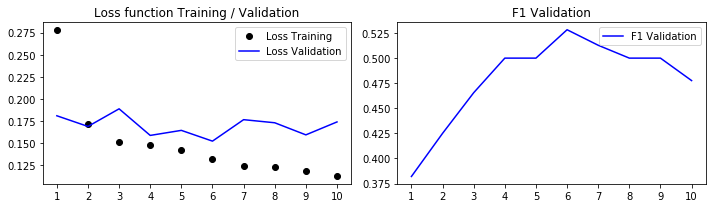

Split: 1 


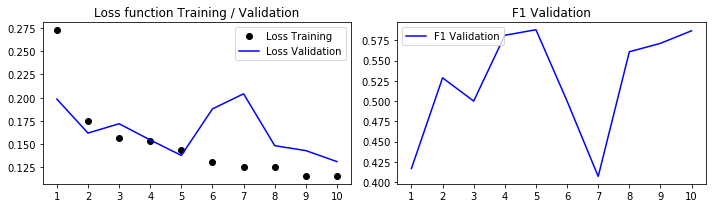

Split: 2 


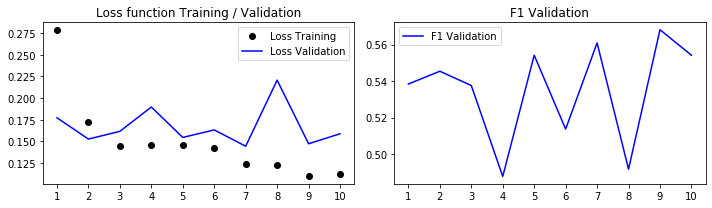

In [22]:
for i in my_history_dict:
    
    print('Split: {} '.format(i))
    loss = my_history_dict[i].history['loss']
    val_loss = my_history_dict[i].history['val_loss']
    epochs = np.arange(1, len(loss) +1, 1) # x-axis

    # Plotting:
    f = plt.figure(figsize=(10,3))
    # plots loss
    f.add_subplot(1, 2, 1) # number of rows, number of columns,subplot you're currently on.
    plt.xticks(epochs)
    plt.plot(epochs, loss, 'bo', label='Loss Training', color = 'black')
    plt.plot(epochs, val_loss, 'b', label='Loss Validation')
    plt.title('Loss function Training / Validation')
    plt.legend()
 
    # plots f1 score
    f.add_subplot(1, 2, 2)
    best_val_f1s = my_metrics_dict[i].best_val_f1s
   # plt.figure()
    plt.xticks(epochs)
    plt.plot(epochs, best_val_f1s, 'b', label='F1 Validation')
    plt.title('F1 Validation')
    plt.legend()
    
    #plt.subplots_adjust(wspace=0.30) # width reserved for blank space between subplots
    f.tight_layout()
    plt.show()

### 2. Evaluation of model predictions based on metrics for binary classification tasks

* As illustrated in the Data Exploration Kernel the Quora dataset is a highly imbalanced dataset. The insincere class (1) only has a small number of samples. For this the keras model has to be careful predicting the toxic class. There are two imporant aspects that should be examined:

        a) Does the model only label a sample as class 1, if it is quite sure ? 
        b) Or does the model make a lot of class 1 predictions in order to cover most of class 1   
           members?
        
*** Confusion matrix, precision and recall is calculated and interpreted**

In [23]:
# Confusion Matrix, Precision and Recall after each Split
for key, value in best_f1_dict.items():
    print(" Split: {} \n Best F1 score: {:6.4f} reached with a threshold of {:6.4f} \n"
          .format(key, best_f1_dict[key], best_threshold_dict[key]))
    print(" Confusion Matrix    Precision    Recall  \n {}{:17.3f}{:10.3f}\n".format(best_confmatrix_dict[key],
                                                                                     best_precision_dict[key],
                                                                                     best_recall_dict[key]))

 Split: 0 
 Best F1 score: 0.5106 reached with a threshold of 0.1400 

 Confusion Matrix    Precision    Recall  
 [[530  31]
 [ 15  24]]            0.436     0.615

 Split: 1 
 Best F1 score: 0.5870 reached with a threshold of 0.2800 

 Confusion Matrix    Precision    Recall  
 [[535  26]
 [ 12  27]]            0.509     0.692

 Split: 2 
 Best F1 score: 0.5542 reached with a threshold of 0.2000 

 Confusion Matrix    Precision    Recall  
 [[540  21]
 [ 16  23]]            0.523     0.590



### 3. Inspecting model predictions in detail

* So far, evaluated model predictions always were transformed into binary class labels based on a threshold. This helps to get a basic understanding about model performance, but does do give enough insights to understand why the model behaves as it does. This section is targeted to **understand why the model makes errors**. Questions to be answered are:
        a) What are insincere questions where the model strongly believes to be sincere ?
        b) What are sincere questions where the model strongly believes to be insincere ?
        c) What are insincere questions where the model is uncertain how to classify ?
        d) What are sincere questions where the model is uncertain how to classify?
    
* Moreover
        e) what kind to questions the model is able to classify correctly with high confidence?

In [0]:
# Create DataFrame for e.g. Split 1 predictions 
i = 1

#q = tokenizer.sequences_to_texts(my_y_val_questions[i]) # transform integer sequences back to questions after preprocessing

# Creates data for DataFrame
d = {'validation_questions (after preprocessing)': my_y_val_questions[i].flatten(),
     'true_labels': my_y_val_targets[i],
     'predicted_probabilities': list(my_y_val_preds[i]),
     'predicted_labels': list(my_y_val_preds[i] >= best_threshold_dict[i]),
    }
preds_in_detail = pd.DataFrame(data=d)

In [25]:
preds_in_detail.predicted_labels = preds_in_detail.predicted_labels.astype(int)
preds_in_detail.true_labels = preds_in_detail.true_labels.astype(int)
preds_in_detail.head()

,validation_questions (after preprocessing),true_labels,predicted_probabilities,predicted_labels
0,Do FL police record any data when they check a citizen 's ID without issuance of any citations or infractions ?,0,[0.035562396],0
1,Where can I buy unique and quirky products online ?,0,[0.00093594193],0
2,"Why do Chinese eat snakes , dogs , crocodiles , alligators , insects , scorpions and everything they could find ?",1,[0.49885005],1
3,What countries play a leading military role in NATO ?,0,[0.01356402],0
4,Can you get sick from old water ?,0,[0.0419285],0


####       a) What are insincere questions where the model strongly believes to be sincere ?

* This is the most important question. A machine learning model for toxic coment classification should be able to clearly identify insincere questions. Attacks against individuals or groups must be reduced to the minimum to keep online conversations fruitful. It is better if the model identifies some non-toxic questions as toxic than the other way around. 

* Code section from above were necessary information for this section were gathered:
        y_val_pred = model.predict(X_val) # prediction on valiation set
        my_y_val_questions[i] = X_val
        my_y_val_preds[i] = y_val_pred 
        my_y_val_targets[i] = y_val

In [26]:
# Inspecting Wrong Labels: true class is toxic (1), but models predics sincere (0)
wrong_labels = preds_in_detail
wrong_labels['wrong label'] = (preds_in_detail['true_labels'] == 1) & (preds_in_detail['predicted_labels'] == 0) 
wrong_labels = wrong_labels[wrong_labels['wrong label'] == True]

# Top 10 
wrong_labels.sort_values(by=['predicted_probabilities'], ascending = False).head(10)

,validation_questions (after preprocessing),true_labels,predicted_probabilities,predicted_labels,wrong label
481,Does the African-American culture not value fatherhood ?,1,[0.23048246],0,True
159,Why has artificial intellect from Amazon been colored with bias against Christianity and Pro-Islam ?,1,[0.20025122],0,True
503,Who is paying for the royal family besides the Brits ?,1,[0.19494548],0,True
249,"Psychologist form relationships w clients for money , and induce clients to replicate relationships with them . Are they manipulative whores ?",1,[0.18010396],0,True
26,"Look in the mirror & find yourself too attractive , that is not Freudian mental health , so what about those attracted to the same sex , similar problem ?",1,[0.14107883],0,True
217,How do I train my dogs to kill raccoons ?,1,[0.11998731],0,True
150,What is so wrong with the mental health of Indian men ?,1,[0.104120016],0,True
490,Which babies are more sweeter to their parents ? Dark skin babies or light skin babies ?,1,[0.10221285],0,True
169,Is Mercedes R. Lackey jealous of the amount of praises Elon musk gets on Quora ?,1,[0.09590563],0,True
407,How do I marry an American woman for a Green Card ? How much do they charge ?,1,[0.094560534],0,True


In [27]:
del wrong_labels; gc.collect()

11115

#### b) What are sincere questions where the network strongly believes to be insincere ?

In [28]:
# Inspecting Wrong Labels: true class is bot-toxic (1), but models predics insincere (1)
wrong_labels = preds_in_detail
wrong_labels['wrong label'] = (preds_in_detail['true_labels'] == 0) & (preds_in_detail['predicted_labels'] == 1) 
wrong_labels = wrong_labels[wrong_labels['wrong label'] == True]

# Top 10 
wrong_labels.sort_values(by=['predicted_probabilities'], ascending = False).head(10)

,validation_questions (after preprocessing),true_labels,predicted_probabilities,predicted_labels,wrong label
580,Why do you think moderate and low functioning people with autism are trained to be heroes like being nice to other ones who 're a lot like them ?,0,[0.76517797],1,True
106,Why super respectful and successful entrepreneurs who are millionaires or billionaires do not want to be lead in politics ?,0,[0.749891],1,True
455,Why does not the world acknowledge that Hitler was a result of a cruel society ? Whats to stop another occurrence in this society ?,0,[0.7036246],1,True
202,How can I forcibly convert all Chinese people to Sunni Wahabbi Islam ?,0,[0.6793042],1,True
562,Why do so many Asians wear masks ?,0,[0.67480063],1,True
78,"Girls hate me , but they hate me even more when boys are around me , what do I do ?",0,[0.65813595],1,True
165,can not we live without the protection of religion as we see every religion is full of conservative ideas ?,0,[0.64758646],1,True
190,"Why does it seem like humans prefer to conquer and dominate other cultures and nature , rather than more peaceful alternatives ?",0,[0.6196599],1,True
478,Would you say nosy people are untrustworthy and have bad intentions ?,0,[0.5966112],1,True
91,Has Donald Trump perpetuated sexism ?,0,[0.59166676],1,True


In [29]:
del wrong_labels; gc.collect()

11

#### c) What are insincere questions where the model is uncertain how to classify ?

* uncertainty in this case means, that the predicted probability of a sample is at or close around the decision boundary (threshold)

In [0]:
# Finds top N closest numbers to threshold of split i
x0 = best_threshold_dict[i]
n = 100
mylist = preds_in_detail['predicted_probabilities']
n_closest = heapq.nsmallest(n, mylist, key=lambda x: abs(x-x0))

In [31]:
# Inspecting Wrong Labels: true class is toxic (1), but models is unsure (probablity close to threshold)
wrong_labels = preds_in_detail
wrong_labels['wrong label'] = (preds_in_detail['true_labels'] == 1) & (preds_in_detail.predicted_probabilities.isin(n_closest) )
wrong_labels = wrong_labels[wrong_labels['wrong label'] == True]

# Top 10 
wrong_labels.head(10)

,validation_questions (after preprocessing),true_labels,predicted_probabilities,predicted_labels,wrong label
26,"Look in the mirror & find yourself too attractive , that is not Freudian mental health , so what about those attracted to the same sex , similar problem ?",1,[0.14107883],0,True
56,Why do psychopaths rape animals ?,1,[0.39278802],1,True
94,Would you date a girl who had sex with a horse or a bull ?,1,[0.3877418],1,True
150,What is so wrong with the mental health of Indian men ?,1,[0.104120016],0,True
159,Why has artificial intellect from Amazon been colored with bias against Christianity and Pro-Islam ?,1,[0.20025122],0,True
169,Is Mercedes R. Lackey jealous of the amount of praises Elon musk gets on Quora ?,1,[0.09590563],0,True
192,Why are South Indian dishes which are prepared by North Indians more tasty than dishes prepared by South Indian restaurants ?,1,[0.32416904],1,True
217,How do I train my dogs to kill raccoons ?,1,[0.11998731],0,True
249,"Psychologist form relationships w clients for money , and induce clients to replicate relationships with them . Are they manipulative whores ?",1,[0.18010396],0,True
271,Women 's are dangerous species in earth ?,1,[0.46739677],1,True


In [32]:
del wrong_labels; gc.collect() # Garbage Cleaner

11

#### d) What are sincere questions where the model is uncertain how to classify?

In [33]:
# Inspecting Wrong Labels: true class is not toxic (0), but models is unsure (probablity close to threshold)
wrong_labels = preds_in_detail
wrong_labels['wrong label'] = (preds_in_detail['true_labels'] == 0) & (preds_in_detail.predicted_probabilities.isin(n_closest) )
wrong_labels = wrong_labels[wrong_labels['wrong label'] == True]

# Top 10 
wrong_labels.head(10)

,validation_questions (after preprocessing),true_labels,predicted_probabilities,predicted_labels,wrong label
7,How can I volunteer to go to Puerto Rico to help with the problem of no drivers to get the products inland from the docks ?,0,[0.08401698],0,True
12,"Would you like to kiss a guy , after he is been down there doing great job , having all your juices on his mouth ?",0,[0.16486478],0,True
21,Why are all fitness YouTubers way stronger than everyone I see at my gym ?,0,[0.21106866],0,True
27,What would you do if you had total obedience over all living creatures for one day ?,0,[0.14428094],0,True
29,Why does my grandmother call wrestling wrastling ?,0,[0.19145164],0,True
35,Do all public school teachers automatically get vacation whenever they ask for it ?,0,[0.18584663],0,True
41,Do people from Northern Ireland consider themselves to be Irish ?,0,[0.24531844],0,True
44,Which are the best books to read for Indian politics and which tells truth about all the political matter ?,0,[0.14515758],0,True
50,"How do I make a girlfriend in Bangalore ? I work in IT , have sufficient money , and I am good looking . And No girls at workplace .",0,[0.123604625],0,True
61,Why did Krishna show the universal from answer ?,0,[0.10795522],0,True


In [34]:
del wrong_labels; gc.collect()

11

#### e) what kind to questions the model is able to classify correctly with high confidence?

In [35]:
# Top 5 were the model is quite sure that sample belongs to class 0
preds_in_detail.sort_values(by = ['predicted_probabilities'], ascending = True)[:5]

,validation_questions (after preprocessing),true_labels,predicted_probabilities,predicted_labels,wrong label
45,What creative jobs can I take up and where ?,0,[3.7372112e-05],0,False
456,What was Miranda Cosgrove 's childhood like ?,0,[4.145503e-05],0,False
440,What exactly are atoms ?,0,[4.7773123e-05],0,False
445,What is CDP in network interface ?,0,[6.017089e-05],0,False
483,What is osn ?,0,[7.3969364e-05],0,False


In [36]:
# Top 5 were the model is quite sure that sample belongs to class 1
preds_in_detail.sort_values(by = ['predicted_probabilities'], ascending = False)[:5]

,validation_questions (after preprocessing),true_labels,predicted_probabilities,predicted_labels,wrong label
359,"Is Indians are slave of English , why they think that guys who can speak English are more smarter than Hindi speaking person ?",1,[0.9299609],1,False
248,If blacks support school choice and mandatory sentencing for criminals why do not they vote Republican ?,1,[0.9017024],1,False
304,What do liberals think the NRA is ? Why do they protest the NRA and feel they are evil ?,1,[0.8791982],1,False
85,Why does every vegan think that they are saving the planet ?,1,[0.80210733],1,False
389,Why are liberal minorities so voilent towards poeple with diffrent poltical beleifs ? Should supporting trump be a sentence to be imprisoned or savegely attacked ?,1,[0.78565764],1,False


In [37]:
del preds_in_detail; gc.collect()

22

# Submission (Prediction)

* Test data was loaded in section "Execution Data Preparation Functions" - 4.1
* Preprocessing Function was applied to test data in section "Execution Data Preparation Functions" - 4.2
* Test data questions were extracted in section "Execution Data Preparation Functions" - 4.3
* My_tokenizer function was applied to test data in section "Execution Data Preparation Functions" - 4.4


  **-> Test data is available as padded integer sequences**
     

* 1 - This section contains the model prediction to create the submission file
* 2 - This section saved the submission file as kernel output to get a score within the competition

In [38]:
padded_seq_test = X[total_train_samples:]
print("Length numpy array testset:", len(padded_seq_test))
padded_seq_test[0] #sfirst sample a predictipn is made for

Length numpy array testset: 1000


array(['Why do so many women become so rude and arrogant when they get just a little bit of wealth and power ?'],
      dtype=object)

### 1. Model prediction

* model predicts a class probability
* class probability is converted to distinct class labels via a threshold, resulting in question labeling as
         0 (insincere questions) or 1 (sincere questions)
* the optimal threshold was examined during model training (Modeling -  section 3)

In [39]:
# Model Prediction
preds = model.predict(padded_seq_test, batch_size = 256, verbose = 1)
final_preds = preds

# Create a submission dataframe and append relevant columns
submission = pd.DataFrame()
submission['qid'] = test['qid'].values
submission['prediction'] = (final_preds > 0.38).astype(int) # round sigmoid results to integers

# Do test and my submission Dataframe have the same length?
if len(submission) == len(test):
    print("Submission dataframe has the same length as test dataframe with shape:{}".format(submission.shape))
else:
    print("Something is wrong!")
    
submission.head()

1000/1000 [==============================] - 4s 4ms/step
Submission dataframe has the same length as test dataframe with shape:(1000, 2)


,qid,prediction
0,0000163e3ea7c7a74cd7,1
1,00002bd4fb5d505b9161,0
2,00007756b4a147d2b0b3,0
3,000086e4b7e1c7146103,0
4,0000c4c3fbe8785a3090,0


### 2. Submission of predictions

* submission file is saved as kernel output
* based on the submission file the competiton F1-score is calculated

In [0]:
# Submission File as Output
#submission.to_csv('submission.csv', index = False)

# Further Information

* Parts of the Code adapted from: Code from:  https://github.com/strongio/keras-elmo/blob/master/Elmo%20Keras.ipynb
* TensorflowHub: https://tfhub.dev/
* ElMO on TF Hub: https://tfhub.dev/google/elmo/3 